# Tuesday Health: Hospice Quality Metrics Technical Assessment
Author: Kyle Biron  

### Imports

In [1]:
import duckdb
import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import os

from pprint import pprint

# configure pandas to show full string values and all rows/columns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### Connect to db

In [2]:
# set the db_dir to the correct path relative to the current working directory
project_root = os.getcwd()
db_dir = os.path.join(project_root, "..", "db", "hospice_quality_metrics.db")

# connect to the existing duckdb database (make sure to have hospice_quality_metrics.db generated via dbt run)
con = duckdb.connect(db_dir)

# list and print all tables in the connected duckdb database
tables = con.execute("show tables").df()
print(tables)

                                              name
0                   dim_hospice_provider_geography
1                  fact_hospice_provider_flattened
2  fact_hospice_provider_missing_metrics_by_region
3                             stg_hospice_provider
4                   stg_hospice_provider_flattened


### 1. Correlation Analysis: HIS Composite Process Metric & HCI Decile

**Prompt**: How correlated is the HIS composite process metric and the HCI decile?  Based on the HIS process metric distribution, what do you think the pros and cons are of this quality measure?

**Section intro:**
- ```fact_hospice_provider_flattened``` is the flattened table from ```hospice_quality_metrics.db``` 
    - ```h_008_01_observed``` is the HIS Composite Measure
    - ```h_012_00_observed``` is the HCI Decile
- This dataframe will be used for the correlation analysis between the two measures
- Note that executing the ```corr()``` pandas method only retains the CCNs that have BOTH measures populated
    - A side-analyis (see appendix) shows that out of the 7132 CCNs, **2765 (or ~39%)** of CCNs were excluded for this correlation analysis
    - CMS Region 9 (San Francisco: Arizona, California, Hawaii, Nevada, Pacific
Territories) was primarily impacted with this exclusion, as **63.36%** of their CCNs were missing at least one measure 

In [3]:
# use con.execute() to create a df
fact_hospice_provider_flattened_df = con.execute("SELECT * FROM fact_hospice_provider_flattened").df()

# preview the df
fact_hospice_provider_flattened_df.head(5)

,ccn,cms_region,h_001_01_denominator,h_001_01_observed,h_002_01_denominator,h_002_01_observed,h_003_01_denominator,h_003_01_observed,h_004_01_denominator,h_004_01_observed,h_005_01_denominator,h_005_01_observed,h_006_01_denominator,h_006_01_observed,h_007_01_denominator,h_007_01_observed,h_008_01_denominator,h_008_01_observed,h_011_01_denominator,h_011_01_observed,h_012_00_observed,h_012_01_denominator,h_012_01_observed,h_012_01_percentile,h_012_02_denominator,h_012_02_observed,h_012_02_percentile,h_012_03_denominator,h_012_03_observed,h_012_03_percentile,h_012_04_denominator,h_012_04_observed,h_012_04_percentile,h_012_05_denominator,h_012_05_observed,h_012_05_percentile,h_012_06_denominator,h_012_06_observed,h_012_06_percentile,h_012_07_denominator,h_012_07_observed,h_012_07_percentile,h_012_08_denominator,h_012_08_observed,h_012_08_percentile,h_012_09_denominator,h_012_09_observed,h_012_09_percentile,h_012_10_denominator,h_012_10_observed,h_012_10_percentile,average_daily_census,bene_dual_pct,bene_ma_pct,care_provided_assisted_living,care_provided_home,care_provided_inpatient_hospice,care_provided_inpatient_hospital,care_provided_nursing_facility,care_provided_skilled_nursing,care_provided_other_locations,pct_pts_w_cancer,pct_pts_w_circ_heart_disease,pct_pts_w_dementia,pct_pts_w_resp_disease,pct_pts_w_stroke,pct_pts_w_other_conditions,provided_home_care_and_other,provided_home_care_only,los_proxy,cms_region_1,cms_region_2,cms_region_3,cms_region_4,cms_region_5,cms_region_6,cms_region_7,cms_region_8,cms_region_9,cms_region_10
0,A11506,9,18,None,18,None,18,None,11,None,18,None,15,None,1,None,18,NaN,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,0,0,0,0,0,0,0,0,1,0
1,A11509,9,27,100.0,27,100.0,27,100.0,22,90.9,27,100.0,20,100.0,1,None,27,92.6,None,None,4.0,"12,087",0.0,49,65,100,100,40,2.5,24,40,22.5,12,40,2.5,27,40,7.5,95,83.0,29603.0,95,"12,087",6.1,3,"73,920",8.5,56,14,42.9,2,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,149.0,0,0,0,0,0,0,0,0,1,0
2,A11527,9,94,100.0,94,100.0,94,100.0,28,92.9,94,100.0,87,97.7,10,None,94,94.7,None,None,10.0,"7,782",0.7,84,54,53.7,45,38,7.9,63,38,23.7,14,38,5.3,43,38,5.3,89,76.0,23091.0,84,"7,726",13.8,65,"106,890",19.9,96,19,100,100,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,116.0,0,0,0,0,0,0,0,0,1,0
3,A11585,9,32,56.3,32,28.1,32,100.0,22,95.5,32,96.9,20,95.0,10,None,32,18.8,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,0,0,0,0,0,0,0,0,1,0
4,A11596,9,1,None,1,None,1,None,1,None,1,None,1,None,0,None,1,NaN,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,0,0,0,0,0,0,0,0,1,0


#### Examining the distribution of HIS Composite Measure and HCI Decile

- The plots below display the distribution for both measures
- Both measures appear right-skewed, with most of the CCNs yeilding higher performance

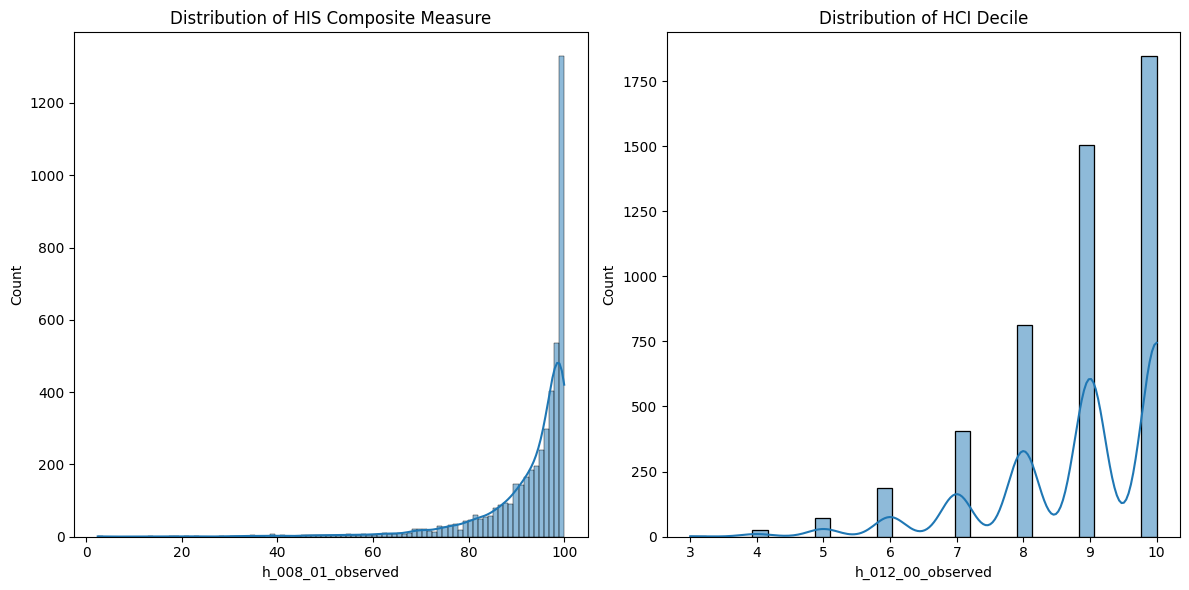

In [4]:
# configure subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# HIS Composite Measure plot
sns.histplot(
    data=fact_hospice_provider_flattened_df, x="h_008_01_observed", kde=True, ax=axes[0]
)
axes[0].set_title("Distribution of HIS Composite Measure")

# HCI Decile plot
sns.histplot(
    data=fact_hospice_provider_flattened_df, x="h_012_00_observed", kde=True, ax=axes[1]
)
axes[1].set_title("Distribution of HCI Decile")

# show plots
plt.tight_layout()
plt.show()

#### Evaluating the correlation between HIS composite measure and HCI decile

- Initially included only the Pearson correlation coefficient, but since the metric distributions did not meet the normal distribution assumption, the Spearman correlation coefficient was also included
  - The Anderson-Darling test for normality was not used to confirm, but we can clearly see from the histograms that the distributions are not normal 
- Both correlation coefficients (**~0.22**) indicate a **weak positive relationship**, which suggests that these two measures may fundamentally reflect different signals of hospice care quality 

In [5]:
# Pearson correlation
correlation_pearson = fact_hospice_provider_flattened_df[
    ["h_008_01_observed", "h_012_00_observed"]
].corr()

# Spearman correlation
correlation_spearman = fact_hospice_provider_flattened_df[
    ["h_008_01_observed", "h_012_00_observed"]
].corr(method="spearman")

# report out correlation coefficients
print("Correlation Matrix: Pearson\n")
print(correlation_pearson)
print("\n" + "-" * 50 + "\n")
print("Correlation Matrix: Spearman\n")
print(correlation_spearman)

Correlation Matrix: Pearson

                   h_008_01_observed  h_012_00_observed
h_008_01_observed           1.000000           0.223246
h_012_00_observed           0.223246           1.000000

--------------------------------------------------

Correlation Matrix: Spearman

                   h_008_01_observed  h_012_00_observed
h_008_01_observed           1.000000           0.227345
h_012_00_observed           0.227345           1.000000


- Even by evaluating the Spearman coefficient by ```cms_region``` (see below), we do not observe any significant improvement in the correlation between the HIS composite measure and the HCI decile
- Region 10 has arguably the "strongest" relationship (**~0.28**) between HIS composite measure and the HCI decile, whereas Region 4 has little to no relationship (**~0.04**)
    - 10 = Seattle: Alaska, Idaho, Oregon, Washington
    - 4 = Atlanta: Alabama, Florida, Georgia, Kentucky, Mississippi, North Carolina, South Carolina, Tennessee      

In [6]:
# Spearman correlation by region
correlation_spearman_by_region = fact_hospice_provider_flattened_df.groupby(
    "cms_region"
)[["h_008_01_observed", "h_012_00_observed"]].corr(method="spearman")

# report out correlation coefficients
print("Correlation Matrix: Spearman by cms_region\n")
print(correlation_spearman_by_region)

Correlation Matrix: Spearman by cms_region

                              h_008_01_observed  h_012_00_observed
cms_region                                                        
1          h_008_01_observed           1.000000           0.174107
           h_012_00_observed           0.174107           1.000000
2          h_008_01_observed           1.000000           0.205653
           h_012_00_observed           0.205653           1.000000
3          h_008_01_observed           1.000000           0.253217
           h_012_00_observed           0.253217           1.000000
4          h_008_01_observed           1.000000           0.044258
           h_012_00_observed           0.044258           1.000000
5          h_008_01_observed           1.000000           0.155562
           h_012_00_observed           0.155562           1.000000
6          h_008_01_observed           1.000000           0.231899
           h_012_00_observed           0.231899           1.000000
7          h_008_0

**In summary:**
- HIS composite measure and HCI decile are only **slightly** related (positive direction)
- **Pros** of HIS composite process metric
  - HIS captures patient-level data on admissions and discharges, which indicates more of a process-specific measure
  - Being a process-specific measure facilitates easier data collection for CCNs
  - References: [HIS Manual](https://www.cms.gov/files/document/hismanualv302apr152024.pdf)
- **Cons** of HIS composite process metric
  - Again, since this measure captures data on admissions and discharges, signals regarding cost and utilization may not be captured
  - In other words, there are CCNs who perform well on adhering to the administrative processes of admission/discharges, but perform poorly on cost/utilization/outcomes (i.e. CCN:111743, HIS: 100, HIC: 4.0)
  - Scatterplot below highlights some of these patterns
  - In general (not just specific to HIS), there is variability of measure availability across all ```cms_region```, indicating some regions have less hospice resources and than others 

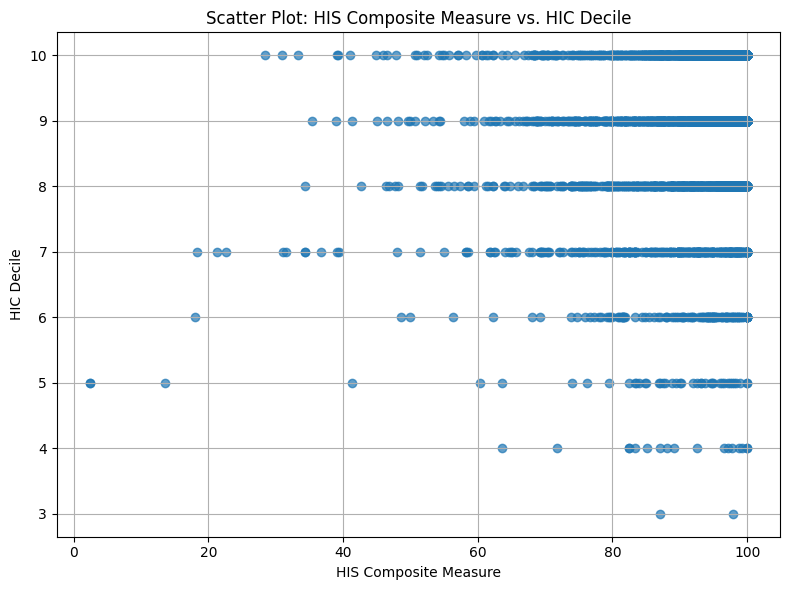

In [7]:
plt.figure(figsize=(8, 6))

# configure scatter plot
plt.scatter(
    fact_hospice_provider_flattened_df["h_008_01_observed"],
    fact_hospice_provider_flattened_df["h_012_00_observed"],
    alpha=0.7,
)

# configure title and labels
plt.title("Scatter Plot: HIS Composite Measure vs. HIC Decile")
plt.xlabel("HIS Composite Measure")
plt.ylabel("HIC Decile")

# show plot
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. LOS Modeling

**Prompt:**
 This dataset provides some information on the condition mix at each hospice (cancer, heart disease, dementia, respiratory disease, stroke).  Based on the hospice-level patient mix, which conditions appear to have longer hospice lengths-of-stay?  Note: this dataset doesn’t have a LOS variable.  However, you can use an average per diem of $200 to convert per-beneficiary spending to a LOS (this is the approximate per-diem for RHC (routine home care) which constitutes the majority of hospice claims).  Based on this finding, do you have any concerns about the construction of the HCI quality measure?


**Section intro:**
- This section of the analysis also uses ```fact_hospice_provider_flattened_df``` from above
- ```h_012_07_observed``` (HCI: Per-beneficiary spending in USD) was used to proxy a new LOS called ```los_proxy```
  - ```los_proxy = h_012_07_observed / 200```
  - since LOS should really be an integer, the ```ceil()``` function was used on ```los_proxy``` to round the LOS to the next integer, when resulting in a decimal (this transformation happens in the ETL)
- Goal is to determine which conditions appear to have longer hospice LOS
- The columns below are the dependent variables to model ```los_proxy``` in a linear regression:
    - ```pct_pts_w_cancer```
    - ```pct_pts_w_circ_heart_disease```
    - ```pct_pts_w_dementia```
    - ```pct_pts_w_resp_disease```
    - ```pct_pts_w_stroke```
    - ```pct_pts_w_other_conditions```
- added ```cms_region``` plot to view region distribution

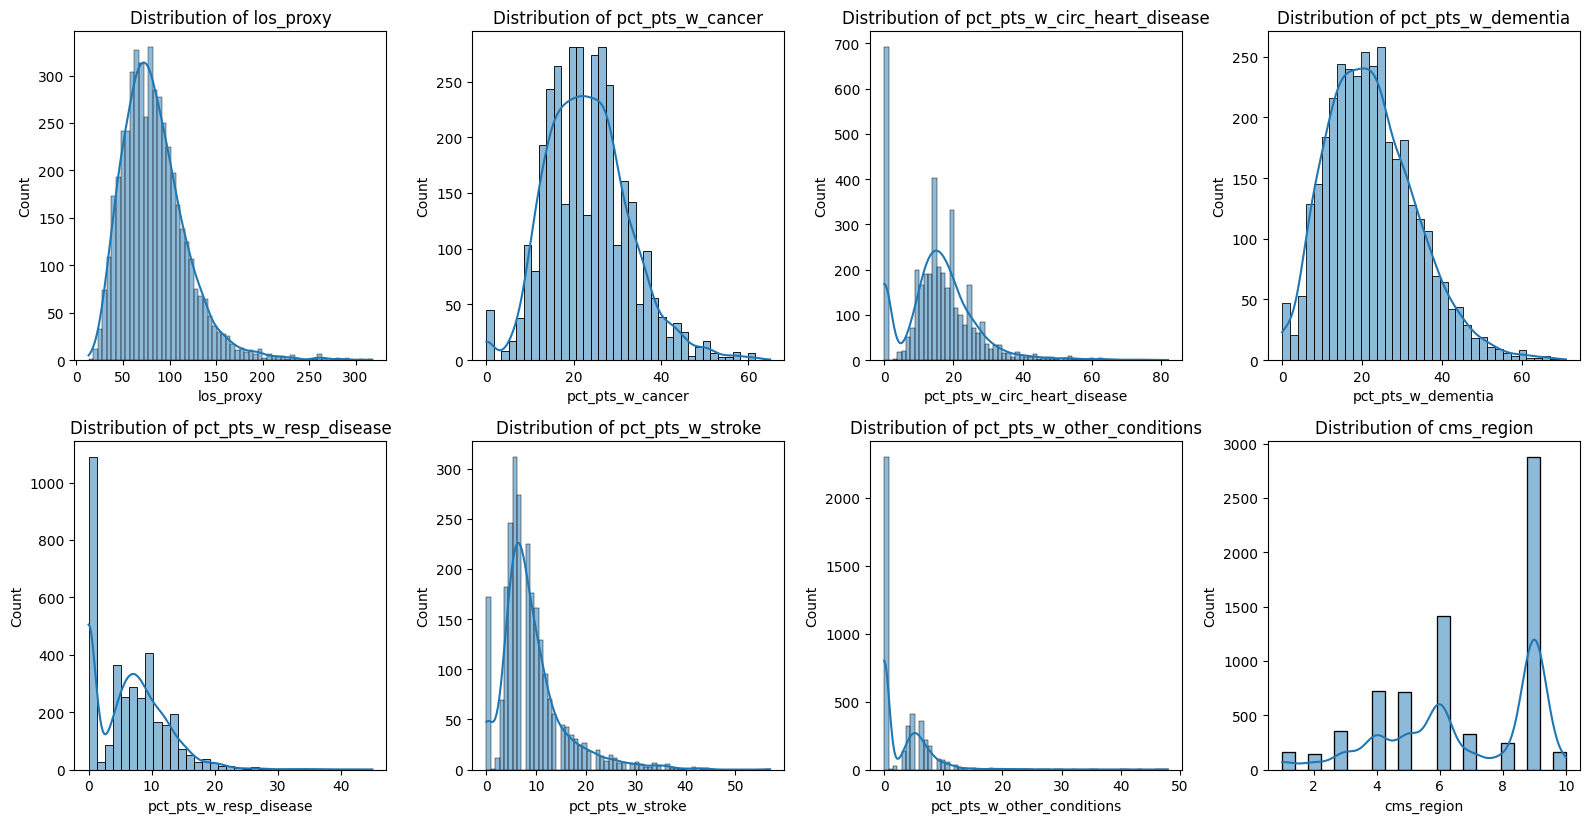

In [8]:
# below are the variables to observe
columns = [
    "los_proxy",
    "pct_pts_w_cancer",
    "pct_pts_w_circ_heart_disease",
    "pct_pts_w_dementia",
    "pct_pts_w_resp_disease",
    "pct_pts_w_stroke",
    "pct_pts_w_other_conditions",
    "cms_region",
]

# configure plots
plt.figure(figsize=(16, 12))

# loop through each column and show plots
for i, col in enumerate(columns, 1):
    plt.subplot(len(columns) // 4 + 1, 4, i)
    sns.histplot(fact_hospice_provider_flattened_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()


**Notes on feature engineering:**
- Since this analysis is exploratory, minimal feature engineering was used during this section
- The primary feature engineering steps involved:
    - Dropping records where LOS was null (due to ```h_012_07_observed``` being unavailable for a CCN)
    - Optionally imputing input features with the median (due to the skewness of the distributions)
    - Optionally applying an upper-outlier threshold to the input features (also due to the skewness of the distributions)
- Did not perform any ```log``` or ```sqrt``` transformations; wanted to keep findings as interpretable as possible for this iteration
- Did not include any interaction terms for this iteration, for the same reason as above


In [9]:
def linear_regression_los(
    X, y, impute=False, remove_outliers=False, outlier_quantile=0.975
):

    """
    Predict LOS using a linear regression model from scikit-learn

    Parameters:
    - X (pd.DataFrame): The feature matrix, where rows are samples and columns are features
    - y (pd.Series or np.ndarray): The target variable corresponding to the rows in X
    - impute (bool, default=False): If True, imputes missing values in X using the median
    - remove_outliers (bool, default=False): If True, remove rows with outliers in any feature
    - outlier_quantile (float, default=0.975): Quantile threshold for outlier removal (used when remove_outliers=True)
        - i.e. 0.975 removes the top 2.5% of outliers

    Returns:
    - model (LinearRegression): The trained linear regression model object
    - X_train (pd.DataFrame): The feature matrix used for training (after any preprocessing)
    """

    # print the number of rows before any feature engineering
    print(f"Number of rows before any feature engineering: {len(X)}")

    # this section is needed to determine if we would like to impute missing values with median
    if impute:

        # impute missing values in X with the median of each column
        X = X.fillna(X.median())
        print("Missing values were imputed using the median.")

    else:

        # drop rows where either X or y has null values
        data_cleaned = pd.concat([X, y], axis=1).dropna()
        X = data_cleaned.drop(columns="los_proxy")
        y = data_cleaned["los_proxy"]
        print(f"Number of rows after removing all nulls from X and y: {len(X)}")

    # drop records where LOS is null
    data = pd.concat([X, y], axis=1).dropna(subset=["los_proxy"])
    X = data.drop(columns="los_proxy")
    y = data["los_proxy"]

    # want the ability remove outliers as optional
    # remove outliers based on the specified quantile threshold
    if remove_outliers:

        # get the quantile for each feature
        quantiles = X.quantile(outlier_quantile)

        # checks whether all features in a particular row are less than or equal to their corresponding quantile values
        X_cleaned = X[(X <= quantiles).all(axis=1)]

        # re-bind X with y
        y_cleaned = y[X_cleaned.index]
        excluded_records = len(X) - len(X_cleaned)
        print(
            f"Number of records excluded due to outliers (quantile {outlier_quantile}): {excluded_records}"
        )
        X, y = X_cleaned, y_cleaned
        print(f"Number of rows after feature engineering: {len(X)}")

    # split the data into training and testing sets
    # set to 20% test for now
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=12345
    )

    # fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # apply model to test set
    y_pred = model.predict(X_test)

    # print model results
    print(f"R²: {r2_score(y_test, y_pred)}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

    return model, X_train


def print_model_details(model, X_train):

    """
    Prints the coefficients and y-intercept of a trained linear regression model

    Parameters:
    - model (LinearRegression): The trained linear regression model
    - X_train (pd.DataFrame): The feature matrix used for training the model

    Returns: None
    - This function prints:
        - The coefficients for each feature in the model
        - The intercept (y-intercept) of the model
    """

    # print the coefficients for each feature
    coefficients = pd.DataFrame(
        {"Feature": X_train.columns, "Coefficient": model.coef_}
    )
    print("\nModel Coefficients:")
    print(coefficients)

    # print the intercept
    print(f"\nIntercept (y-intercept): {model.intercept_}")


**Determining the top conditions leading to longer hospice LOS** 
- Model 1: *without* imputation and outlier removal
  - Only had an R-squared of about **~0.35** which means that only about **35% of the variance of LOS is explained by the condition mix**, while the remaining 65% is due to noise not accounted for
  - (1) stroke, (2) dementia, followed by (3) heart disease were indicators of *higher* LOS
- Model 2: *with* imputation and outlier removal performed
  - Yielded an even lower R-squared of about **~0.19** which means that only about **19% of the variance of LOS is explained by the condition mix**, while the remaining 81% is due to noise not accounted for
  - (1) dementia followed by (2) heart disease were indicators of *higher* LOS
  - dementia was no longer a predictor of LOS (could be due to signal lost from feature engineering, as well as lack of considering external factors not included in this model)
- Reasons for lower prediction performance:
  - Not enough feature engineering
  - We are missing additional signal; condition mix may not be enough to predict LOS 

In [10]:
# original feature and target data
X = fact_hospice_provider_flattened_df[
    [
        "pct_pts_w_cancer",
        "pct_pts_w_circ_heart_disease",
        "pct_pts_w_dementia",
        "pct_pts_w_resp_disease",
        "pct_pts_w_stroke",
        "pct_pts_w_other_conditions",
    ]
]
y = fact_hospice_provider_flattened_df["los_proxy"]

# model 1: without imputation or outlier removal
print("Model without imputation and outlier removal:")
model_no_imputation, X_train_no_imputation = linear_regression_los(
    X, y, impute=False, remove_outliers=False
)
print_model_details(model_no_imputation, X_train_no_imputation)

# model 2: with imputation and outlier removal
print("\nModel with imputation and outlier removal:")
model_with_imputation, X_train_with_imputation = linear_regression_los(
    X, y, impute=True, remove_outliers=True, outlier_quantile=0.975
)
print_model_details(model_with_imputation, X_train_with_imputation)

Model without imputation and outlier removal:
Number of rows before any feature engineering: 7132
Number of rows after removing all nulls from X and y: 2078
R²: 0.3482161969149882
Mean Squared Error: 357.81953053401446

Model Coefficients:
                        Feature  Coefficient
0              pct_pts_w_cancer    -0.843521
1  pct_pts_w_circ_heart_disease     0.703844
2            pct_pts_w_dementia     0.739836
3        pct_pts_w_resp_disease    -0.306216
4              pct_pts_w_stroke     0.841213
5    pct_pts_w_other_conditions    -0.032705

Intercept (y-intercept): 61.50951215792736

Model with imputation and outlier removal:
Number of rows before any feature engineering: 7132
Missing values were imputed using the median.
Number of records excluded due to outliers (quantile 0.975): 679
Number of rows after feature engineering: 4194
R²: 0.1942385293729878
Mean Squared Error: 1066.7615257589564

Model Coefficients:
                        Feature  Coefficient
0              pct_

**Expanding upon existing models**
- Model 3 (see below): *without* imputation and outlier removal + considering CMS region
  - Improved R-squared to about **~0.5** which means that about **50% of the variance of LOS is explained by the condition mix and region**, while the remaining 50% is due to other external factors
  - While still not perfect, this model is more reliable than the previous two
  - (1) dementia, (2) heart disease, followed by (3) stroke were indicators of higher LOS
  - A CCN that resided in CMS Region 2 (New York: New Jersey, New York, Puerto Rico, Virgin Islands) was an indicator of *lower* LOS, with about **~8** days *less* than the average of 62 days
  - A CCN that resided in CMS Region 9 (San Francisco: Arizona, California, Hawaii, Nevada, Pacific Territories) was an indicator of *higher* LOS, with about **~23** days *more* than the average of 62 days

In [11]:
# original feature and target data
X = fact_hospice_provider_flattened_df[
    [
        "pct_pts_w_cancer",
        "pct_pts_w_circ_heart_disease",
        "pct_pts_w_dementia",
        "pct_pts_w_resp_disease",
        "pct_pts_w_stroke",
        "pct_pts_w_other_conditions",
        "cms_region_1",
        "cms_region_2",
        "cms_region_3",
        "cms_region_4",
        "cms_region_5",
        "cms_region_6",
        "cms_region_7",
        "cms_region_8",
        "cms_region_9",
        "cms_region_10",
    ]
]
y = fact_hospice_provider_flattened_df["los_proxy"]

# model 2: without imputation or outlier removal, add cms_region
print("Model without imputation and outlier removal:")
model_no_imputation, X_train_no_imputation = linear_regression_los(
    X, y, impute=False, remove_outliers=False
)
print_model_details(model_no_imputation, X_train_no_imputation)

Model without imputation and outlier removal:
Number of rows before any feature engineering: 7132
Number of rows after removing all nulls from X and y: 2078
R²: 0.4953345788759881
Mean Squared Error: 277.05374574917414

Model Coefficients:
                         Feature  Coefficient
0               pct_pts_w_cancer    -0.846542
1   pct_pts_w_circ_heart_disease     0.628703
2             pct_pts_w_dementia     0.708042
3         pct_pts_w_resp_disease    -0.185371
4               pct_pts_w_stroke     0.615654
5     pct_pts_w_other_conditions     0.042320
6                   cms_region_1     2.297981
7                   cms_region_2    -8.055261
8                   cms_region_3    -4.535009
9                   cms_region_4    -0.230184
10                  cms_region_5    -4.376015
11                  cms_region_6     3.042824
12                  cms_region_7    -6.314184
13                  cms_region_8    -2.350597
14                  cms_region_9    22.770177
15                 cms_r

**In Summary**
- While not being the sole predictors of hospice LOS: higher rates of dementia, heart disease, stroke were the top indicators of LOS from a condition-mix perspective (for a given CCN).
    - These conditions may skew the HCI measure, as these conditions may simply require additional LOS due to the nature of the conditions (and may not be indicative of quality)
- Region does play a role in the variability of LOS, thus potentially impacting the HCI measure
    - This includes member-access to care as well as socioeconomic factors not considered by the HCI measure

### Project Retrospective and Summary
- Please refer to the [Retrospective](https://docs.google.com/document/d/1SECftKCQdrU6C_VH_hN-ZWl7HQkYOIakkvui1QyOsz0/edit#bookmark=id.eq1ea5nmyxgr) section of the journal 

### Appendix

####  CCNs without having both HIS and HCI by region

referenced from the data dictionary:  
- 1 = Boston: Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont  
- 2 = New York: New Jersey, New York, Puerto Rico, Virgin Islands  
- 3 = Philadelphia: Delaware, District of Columbia, Maryland, Pennsylvania, Virginia, West Virginia  
- 4 = Atlanta: Alabama, Florida, Georgia, Kentucky, Mississippi, North Carolina, South Carolina, Tennessee  
- 5 = Chicago: Illinois, Indiana, Michigan, Minnesota, Ohio, Wisconsin  
- 6 = Dallas: Arkansas, Louisiana, New Mexico, Oklahoma, Texas  
- 7 = Kansas City: Iowa, Kansas, Missouri, Nebraska  
- 8 = Denver: Colorado, Montana, North Dakota, South Dakota, Utah, Wyoming  
- 9 = San Francisco: Arizona, California, Hawaii, Nevada, Pacific Territories  
- 10 = Seattle: Alaska, Idaho, Oregon, Washington

<Figure size 1000x600 with 0 Axes>

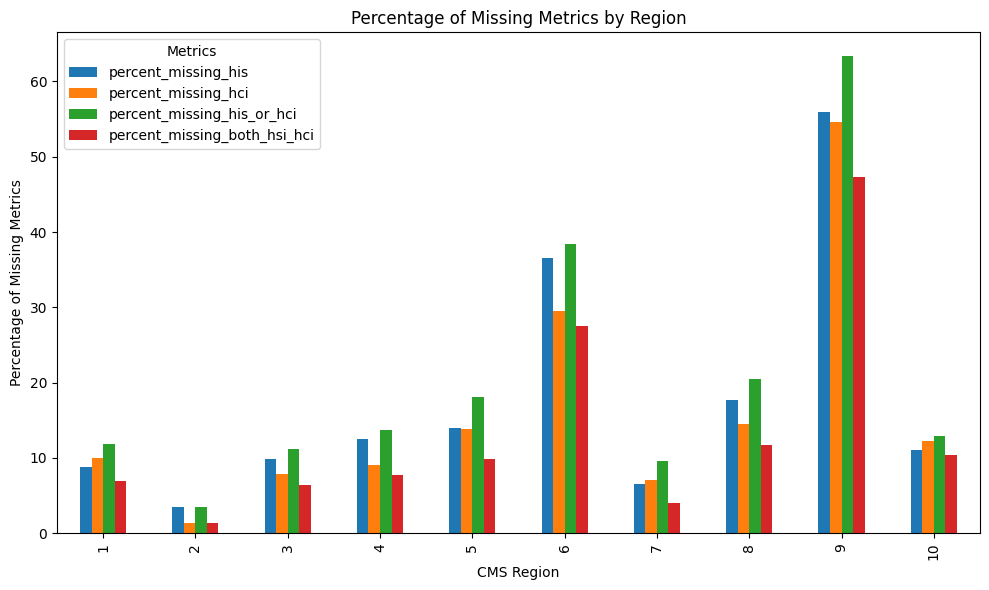

In [12]:
# use con.execute() to create a df
fact_hospice_provider_missing_metrics_by_region_df = con.execute(
    "SELECT * FROM fact_hospice_provider_missing_metrics_by_region"
).df()

# sort df by cms_region
fact_hospice_provider_missing_metrics_by_region_df = (
    fact_hospice_provider_missing_metrics_by_region_df.sort_values("cms_region")
)

# configure size
plt.figure(figsize=(10, 6))

# bar chart
fact_hospice_provider_missing_metrics_by_region_df.plot(
    kind="bar",
    x="cms_region",
    y=[
        "percent_missing_his",
        "percent_missing_hci",
        "percent_missing_his_or_hci",
        "percent_missing_both_hsi_hci",
    ],
    figsize=(10, 6),
)

# configure title and labels
plt.title("Percentage of Missing Metrics by Region")
plt.xlabel("CMS Region")
plt.ylabel("Percentage of Missing Metrics")

# show plot
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()


In [13]:
# use this cell to disconnect from db (needed for dbt run)
con.close()